# Run the CCF analysis
You should have already cross-correlated all your spectra against a suitable model using Search.py. This notebook goes through the shifting and subtracting of the average CCF, and measuring the companion velocities.

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import CombineCCFs
import numpy as np
from astropy import units as u, constants
from HelperFunctions import Gauss, integral
import os
import lmfit
import emcee
import triangle

from scipy.interpolate import InterpolatedUnivariateSpline as spline

sns.set_context('paper', font_scale=2.0)

home = os.environ['HOME']


## Get and shift the Cross-correlation functions to the primary star rest frame

Run with T > 6000 first, to measure the primary star radial velocity in my CCFs. Then, run with T = 4000 or so to detect the companion.

In [32]:
hdf_file = '{}/School/Research/McDonaldData/PlanetData/PsiDraA/Cross_correlations/CCF.hdf5'.format(home)
output_dir = '{}/School/Research/McDonaldData/PlanetData/Paper/Figures/'.format(home)

T = 4500
vsini = 1
logg = 4.5
metal = 0.0
dV = 0.1
c = constants.c.cgs.to(u.m/u.s).value
xgrid = np.arange(-400, 400+dV/2., dV)
ccfs, original_files = CombineCCFs.get_ccfs(T=T, vsini=vsini, logg=logg, metal=metal,
                                        hdf_file=hdf_file, xgrid=xgrid)

(-12.924013515021281, 'RV31378-1_telluric_corrected.fits')
(-13.143010403423075, 'RV31380-1_telluric_corrected.fits')
(-12.003705650106246, 'RV33985-1_telluric_corrected.fits')
(-14.048953684277098, 'RV40657-1_telluric_corrected.fits')
(-13.883806121470315, 'RV41804-1_telluric_corrected.fits')
(-13.915250060662759, 'RV41806-1_telluric_corrected.fits')
(-13.646638138326763, 'RV42158-1_telluric_corrected.fits')
(-13.428089365176973, 'RV42333-1_telluric_corrected.fits')
(-12.535378347673428, 'RV42460-1_telluric_corrected.fits')
(-13.655731306157508, 'RV43838-1_telluric_corrected.fits')
(-12.34735445174174, 'RV44144-1_telluric_corrected.fits')
(-13.249374536972795, 'RV44764-1_telluric_corrected.fits')
(-13.105458495080921, 'RV46786-1_telluric_corrected.fits')
(-13.020718108076688, 'RV46787-1_telluric_corrected.fits')
(-13.317769722370675, 'RV46903-1_telluric_corrected.fits')
(-14.39609472414916, 'RV47237-1_telluric_corrected.fits')
(-13.092534833831255, 'RV47671-1_telluric_corrected.fits')

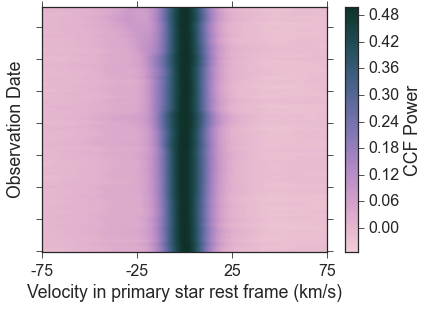

In [33]:
# Plot all the CCFs
cmap = sns.cubehelix_palette(reverse=False, as_cmap=True, gamma=1, rot=0.7, start=2)
fig, ax = plt.subplots(1, 1)
out = ax.imshow(ccfs, cmap=cmap, aspect='auto', origin='lower')#, vmin=vmin, vmax=vmax)
min_v = -75.
max_v = 75.
dv_ticks = 50.0/dV
ax.set_xlim(((min_v+400)/dV, (max_v+400)/dV))
ticks = np.arange((min_v+400)/dV, (max_v+400)/dV+1, dv_ticks)
ax.set_xticks((ticks))
#ax.set_xticklabels((-150, -100, -50, 0, 50, 100, 150))
ax.set_xticklabels((-75, -25, 25, 75))
ax.set_xlabel('Velocity in primary star rest frame (km/s)')
ax.set_yticklabels(())
ax.set_ylabel('Observation Date')

# Colorbar
cb = plt.colorbar(out)
cb.set_label('CCF Power')

# Save
plt.savefig('{}Original_CCFs.pdf'.format(output_dir))

In [34]:
avg_ccf = np.mean(ccfs, axis=0)

In [35]:
normed_ccfs = ccfs - avg_ccf

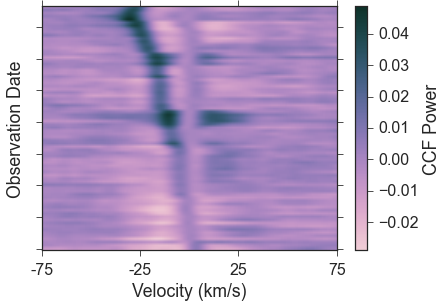

In [36]:
# Set up the scaling manually
low, high = np.min(normed_ccfs), np.max(normed_ccfs)
rng = max(abs(low), abs(high))
vmin = np.sign(low) * rng
vmax = np.sign(high) * rng

# Make the actual plot
#cmap = sns.cubehelix_palette(reverse=False, as_cmap=True, gamma=1, rot=0.7, start=2) #defined above now...
fig, ax = plt.subplots(1, 1)
out = ax.imshow(normed_ccfs, cmap=cmap, aspect='auto', origin='lower')#, vmin=vmin, vmax=vmax)
ax.set_xlim(((min_v+400)/dV, (max_v+400)/dV))
ticks = np.arange((min_v+400)/dV, (max_v+400)/dV+1, dv_ticks)
ax.set_xticks((ticks))
#ax.set_xticklabels((-150, -100, -50, 0, 50, 100, 150))
ax.set_xticklabels((-75, -25, 25, 75))
ax.set_xlabel('Velocity (km/s)')
ax.set_yticklabels(())
ax.set_ylabel('Observation Date')

# Colorbar
cb = plt.colorbar(out)
cb.set_label('CCF Power')

fig.subplots_adjust(bottom=0.18, left=0.10, top=0.95, right=0.90)

plt.savefig('{}Resid_CCFs.pdf'.format(output_dir))

In [38]:
def fwhm(x, y, search_range=(-500, 500)):
    good = (x > search_range[0]) & (x < search_range[1])
    x = x[good].copy()
    y = y[good].copy()
    idx = np.argmax(y)
    ymax = y[idx]
    half_max = ymax / 2.0
    
    # Find the first pixels less than half_max to the left of idx
    for di in range(1, idx):
        if y[idx-di] < half_max:
            break
    slope = (y[idx-(di+1)] - y[idx-di])/(x[idx-(di+1)] - x[idx-di])
    left = x[idx-di] + (half_max - y[idx-di])/slope
    
    # Find the first pixels less than half_max to the right of idx
    for di in range(1, len(x)-idx-1):
        if y[idx+di] < half_max:
            break
    slope = (y[idx+(di+1)] - y[idx+di])/(x[idx+(di+1)] - x[idx+di])
    right = x[idx+di] + (half_max - y[idx+di])/slope
    
    return left, x[idx], right

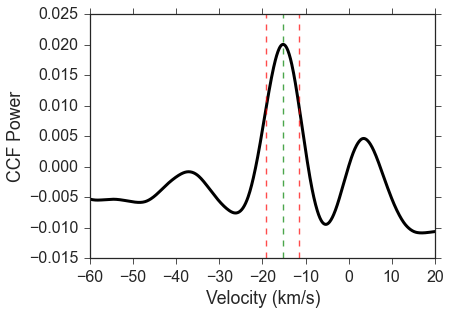

In [39]:
# Make plot of a normal residual CCF
sns.set_style('white')
sns.set_style('ticks')

i = 50
corr = normed_ccfs[i]
fig, ax = plt.subplots()
ax.plot(xgrid, corr, 'k-', lw=3)

l, m, h = fwhm(xgrid, corr, search_range=(-50, 10))
ylim = ax.get_ylim()
ax.plot([m, m], ylim, 'g--', alpha=0.7)
ax.plot([l, l], ylim, 'r--', alpha=0.7)
ax.plot([h, h], ylim, 'r--', alpha=0.7)

ax.set_xlim((-60, 20))
ax.set_ylim(ylim)

ax.set_xlabel('Velocity (km/s)')
ax.set_ylabel('CCF Power')
fig.subplots_adjust(bottom=0.18, left=0.20, top=0.95, right=0.95)

plt.savefig('{}Typical_CCF.pdf'.format(output_dir))

## Measure the companion RVs. 
The measured CCF velocities are in the primary star rest frame + some $\Delta v$ caused by the mismatch between the modeled index of refraction and the real index of refraction at McDonald observatory. That is a constant though. So, we get

$v_m(t) = v_2(t) - v_1(t) + \Delta v$

and

$v_2(t) = v_m(t) + v_1(t) - \Delta v$

where $v_m(t)$ are the measured radial velocities in the residual CCFS. But, all that get's done in the MCMC fitting code. Let's just measure $v_m$ for as many times as possible.

i = 12, HJD = 2454279.75215
	-1.9 +1.3/-1.4
	RV46786-1_telluric_corrected.fits
i = 13, HJD = 2454279.75674
	-1.9 +1.3/-1.4
	RV46787-1_telluric_corrected.fits
i = 14, HJD = 2454309.79142
	-1.6 +1.2/-1.2
	RV46903-1_telluric_corrected.fits
i = 15, HJD = 2454345.62967
	-0.9 +0.6/-0.7
	RV47237-1_telluric_corrected.fits
i = 17, HJD = 2454662.92681
	-4.5 +2.7/-2.5
	RV50253-1_telluric_corrected.fits
i = 18, HJD = 2454665.7677
	-4.2 +2.6/-2.6
	RV50366-1_telluric_corrected.fits
i = 19, HJD = 2454665.77228
	-4.4 +2.7/-2.6
	RV50367-1_telluric_corrected.fits
i = 20, HJD = 2454730.70839
	-4.8 +3.0/-2.9
	RV50755-1_telluric_corrected.fits
i = 22, HJD = 2454750.64164
	-5.1 +3.1/-2.9
	RV51344-1_telluric_corrected.fits
i = 25, HJD = 2454750.6558
	-5.6 +3.4/-3.6
	RV51347-1_telluric_corrected.fits
i = 26, HJD = 2454750.66038
	-5.2 +3.2/-3.3
	RV51348-1_telluric_corrected.fits
i = 27, HJD = 2454750.67062
	-5.2 +3.2/-3.4
	RV51349-1_telluric_corrected.fits
i = 29, HJD = 2454750.67979
	-5.6 +3.4/-3.6
	RV51351-1

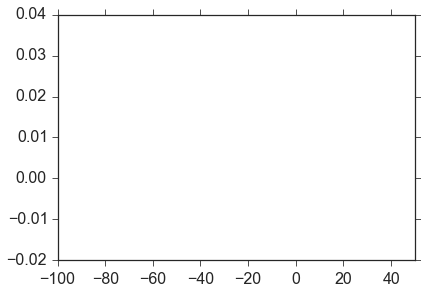

In [40]:
# Measure the radial velocities of the companion as the peak and FWHM of the residual CCF

date = []
rv1 = []
rv1_err = []
rv2 = []
rv2_err = []
reload(CombineCCFs)
import time
for i in range(10, len(original_files)):
#for i in range(20, 21):
    header = CombineCCFs.fits.getheader(original_files[i])
    jd = header['HJD']
    prim_rv = CombineCCFs.get_prim_rv(original_files[i], data_shift=0.0)
    measurements = CombineCCFs.get_measured_rv(original_files[i])
    rv1.append(measurements[0])
    rv1_err.append(measurements[1])
    
    try:
        l, m, h = fwhm(xgrid.copy(), normed_ccfs[i], search_range=(-50, 10))
        print('i = {}, HJD = {}\n\t{:.1f} +{:.1f}/-{:.1f}\n\t{}'.format(i, jd, m, h-m, m-l, original_files[i]))
        date.append(jd)
        rv2.append((h+l)/2.)
        rv2_err.append((h-l)/2.355)
    except:
        date.append(jd)
        rv2.append(np.nan)
        rv2_err.append(np.nan)
        continue
        
    plt.plot(xgrid, normed_ccfs[i])
    plt.xlim((-100, 50))
    ylim = plt.ylim()
    plt.plot([(h+l)/2., (h+l)/2.], ylim, 'g--')
    plt.savefig('Figures/CCF_{}.pdf'.format(original_files[i][:-5]))
    plt.cla()
    
    
rv1 = np.array(rv1)
rv1_err = np.array(rv1_err)
rv2 = np.array(rv2)
rv2_err = np.array(rv2_err)

In [41]:
# Save the RVs
np.savetxt('rv_data.txt', (date, rv1, rv1_err, rv2, rv2_err))